# Project 8: Backtesting

In this project, you will build a fairly realistic backtester that uses the Barra data. The backtester will perform portfolio optimization that includes transaction costs, and you'll implement it with computational efficiency in mind, to allow for a reasonably fast backtest. You'll also use performance attribution to identify the major drivers of your portfolio's profit-and-loss (PnL). You will have the option to modify and customize the backtest as well.


## Instructions

Each problem consists of a function to implement and instructions on how to implement the function.  The parts of the function that need to be implemented are marked with a `# TODO` comment. Your code will be checked for the correct solution when you submit it to Udacity.


## Packages

When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

### Install Packages

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

### Load Packages

In [2]:
import scipy
import patsy
import pickle

import numpy as np
import pandas as pd

import scipy.sparse
import matplotlib.pyplot as plt

from statistics import median
from scipy.stats import gaussian_kde
from statsmodels.formula.api import ols
from tqdm import tqdm

## Load Data

We’ll be using the Barra dataset to get factors that can be used to predict risk. Loading and parsing the raw Barra data can be a very slow process that can significantly slow down your backtesting. For this reason, it's important to pre-process the data beforehand. For your convenience, the Barra data has already been pre-processed for you and saved into pickle files. You will load the Barra data from these pickle files.

In the code below, we start by loading `2004` factor data from the `pandas-frames.2004.pickle` file. We also load the `2003` and `2004` covariance data from the `covaraince.2003.pickle`  and `covaraince.2004.pickle` files. You are encouraged  to customize the data range for your backtest. For example, we recommend starting with two or three years of factor data. Remember that the covariance data should include all the years that you choose for the factor data,   and also one year earlier. For example, in the code below we are using  `2004` factor data, therefore, we must include `2004` in our covariance data, but also the previous year, `2003`. If you don't remember why must include this previous year, feel free to review the lessons.

In [3]:
barra_dir = '../../data/project_8_barra/'

data = {}
for year in [2004]:
    fil = barra_dir + "pandas-frames." + str(year) + ".pickle"
    data.update(pickle.load( open( fil, "rb" ) ))
    
covariance = {}
for year in [2004]:
    fil = barra_dir + "covariance." + str(year) + ".pickle"
    covariance.update(pickle.load( open(fil, "rb" ) ))
    
daily_return = {}
for year in [2004, 2005]:
    fil = barra_dir + "price." + str(year) + ".pickle"
    daily_return.update(pickle.load( open(fil, "rb" ) ))

## Shift Daily Returns Data (TODO)

In the cell below, we want to incorporate a realistic time delay that exists in live trading, we’ll use a two day delay for the `daily_return` data. That means the `daily_return` should be two days after the data in `data` and `cov_data`. Combine `daily_return` and `data` together in a dict called `frames`.

Since reporting of PnL is usually for the date of the returns, make sure to use the two day delay dates (dates that match the `daily_return`) when building `frames`. This means calling `frames['20040108']` will get you the prices from "20040108" and the data from `data` at "20040106".

Note: We're not shifting `covariance`, since we'll use the "DataDate" field in `frames` to lookup the covariance data. The "DataDate" field contains the date when the `data` in `frames` was recorded. For example, `frames['20040108']` will give you a value of "20040106" for the field "DataDate".

In [4]:
frames ={}
dlyreturn_n_days_delay = 2

# TODO: Implement
#print(list(data.items())[0:10])
#print(list(daily_return.items())[0:10])
daily_return_shifted = sorted(daily_return.keys())[dlyreturn_n_days_delay:len(data) + dlyreturn_n_days_delay]
date_shifts = zip(sorted(data.keys()), daily_return_shifted)

for data_date, return_date in date_shifts:
    frames[data_date] = data[data_date].merge(daily_return[return_date], on='Barrid') 



## Add Daily Returns date column (Optional)
Name the column `DlyReturnDate`.
**Hint**: create a list containing copies of the date, then create a pandas series.

In [5]:
# Optional
for DlyReturnDate, df in frames.items():
    n_rows = df.shape[0]
    df['DlyReturnDate'] = pd.Series([DlyReturnDate] * n_rows) 
frames['20040102'].head()

,Barrid,USFASTD_1DREVRSL,USFASTD_AERODEF,USFASTD_AIRLINES,USFASTD_ALUMSTEL,USFASTD_APPAREL,USFASTD_AUTO,USFASTD_BANKS,USFASTD_BETA,USFASTD_BEVTOB,...,ADTCA_30,IssuerMarketCap,Yield,TotalRisk,SpecRisk,HistBeta,PredBeta,DataDate,DlyReturn,DlyReturnDate
0,USA0001,-0.032,0.000,0.0,0.0,0.0,0.0,0.0,-2.177,0.0,...,NaN,5.392988e+10,0.188679,13.959397,9.014505,-0.000189,0.156387,20040102,0.0,20040102
1,USA0011,-0.059,0.000,0.0,0.0,0.0,0.0,0.0,-2.176,0.0,...,NaN,5.874999e+09,0.000000,17.033359,11.726327,0.000013,0.147900,20040102,0.0,20040102
2,USA0031,0.457,0.000,0.0,0.0,0.0,0.0,0.0,-2.061,0.0,...,NaN,7.304963e+10,2.103004,21.738218,18.047415,0.053033,0.216422,20040102,0.0,20040102
3,USA0062,-0.128,0.431,0.0,0.0,0.0,0.0,0.0,-2.003,0.0,...,NaN,2.866562e+10,2.243494,23.129496,20.830128,0.079755,0.355564,20040102,0.0,20040102
4,USA00E2,0.374,0.000,0.0,0.0,0.0,0.0,0.0,-1.967,0.0,...,NaN,5.720420e+10,2.167256,25.391653,21.458171,0.096238,0.412602,20040102,0.0,20040102


## Winsorize

As we have done in other projects, we'll want to avoid extremely positive or negative values in our data. Will therefore create a function, `wins`, that will clip our values to a minimum and maximum range. This process is called **Winsorizing**. Remember that this helps us handle noise, which may otherwise cause unusually large positions.

In [6]:
def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

## Density Plot

Let's check our `wins` function by taking a look at the distribution of returns for a single day `20040102`. We will clip our data from `-0.1` to `0.1` and plot it using our `density_plot` function.

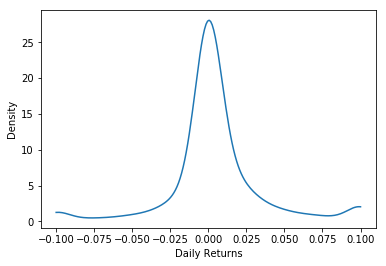

In [7]:
def density_plot(data): 
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs))
    plt.xlabel('Daily Returns')
    plt.ylabel('Density')
    plt.show()
    
test = frames['20040108']
test['DlyReturn'] = wins(test['DlyReturn'],-0.1,0.1)
density_plot(test['DlyReturn'])

## Factor Exposures and Factor Returns

Recall that:

$r_{i,t} = \sum_{j=1}^{k} (\beta_{i,j,t-2} \times f_{j,t})$  
where $i=1...N$ (N assets),   
and $j=1...k$ (k factors).

where $r_{i,t}$ is the return, $\beta_{i,j,t-2}$ is the factor exposure, and $f_{j,t}$ is the factor return. Since we get the factor exposures from the Barra data, and we know the returns, it is possible to estimate the factor returns. In this notebook, we will use the Ordinary Least Squares (OLS) method to estimate the factor exposures, $f_{j,t}$, by using $\beta_{i,j,t-2}$ as the independent variable, and $r_{i,t}$ as the dependent variable.

In [8]:
def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n):
    return list(filter(lambda x: "USFASTD_" in x, n))

def estimate_factor_returns(df): 
    ## build universe based on filters 
    estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
  
    ## winsorize returns for fitting 
    estu['DlyReturn'] = wins(estu['DlyReturn'], -0.25, 0.25)
  
    all_factors = factors_from_names(list(df))
    form = get_formula(all_factors, "DlyReturn")
    model = ols(form, data=estu)
    results = model.fit()
    return results

In [9]:
facret = {}

for date in frames:
    facret[date] = estimate_factor_returns(frames[date]).params

In [10]:
my_dates = sorted(list(map(lambda date: pd.to_datetime(date, format='%Y%m%d'), frames.keys())))

## Choose Alpha Factors

We will now choose our alpha factors. Barra's factors include some alpha factors that we have seen before, such as:

* **USFASTD_1DREVRSL** : Reversal

* **USFASTD_EARNYILD** : Earnings Yield

* **USFASTD_VALUE** : Value

* **USFASTD_SENTMT** : Sentiment

We will choose these alpha factors for now, but you are encouraged to come back to this later and try other factors as well.

<bound method NDFrame.head of             USFASTD_1DREVRSL  USFASTD_EARNYILD  USFASTD_VALUE  USFASTD_SENTMT
2004-01-02          0.002149          0.000642      -0.000988        0.000851
2004-01-05          0.000360         -0.000856      -0.000118        0.001045
2004-01-06          0.000497         -0.002114       0.000843        0.002620
2004-01-07          0.000093          0.001255       0.000170        0.000545
2004-01-08         -0.000032          0.000985       0.000509        0.001214
2004-01-09          0.001245          0.000975       0.000434       -0.000440
2004-01-12          0.000710         -0.000701       0.000205        0.001019
2004-01-13         -0.001168         -0.000389      -0.000389        0.001241
2004-01-14          0.000225         -0.000047       0.000129        0.001538
2004-01-15          0.001676          0.000367       0.001705       -0.001227
2004-01-16          0.001823         -0.000156       0.000017       -0.000511
2004-01-20          0.003213      

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


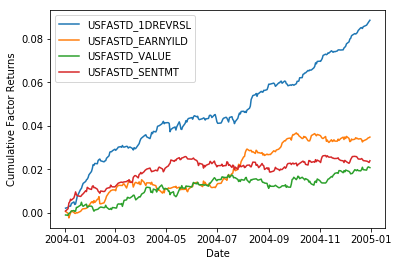

In [11]:
alpha_factors = ["USFASTD_1DREVRSL", "USFASTD_EARNYILD", "USFASTD_VALUE", "USFASTD_SENTMT"]

facret_df = pd.DataFrame(index = my_dates)

for dt in my_dates: 
    for alp in alpha_factors: 
        facret_df.at[dt, alp] = facret[dt.strftime('%Y%m%d')][alp]
print(facret_df.head)
for column in facret_df.columns:
        plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

## Merge Previous Portfolio Holdings 

In order to optimize our portfolio we will use the previous day's holdings to estimate the trade size and transaction costs. In order to keep track of the holdings from the previous day we will include a column to hold the portfolio holdings of the previous day. These holdings of all our assets will be initialized to zero when the backtest first starts.

In [12]:
def clean_nas(df): 
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    for numeric_column in numeric_columns: 
        df[numeric_column] = np.nan_to_num(df[numeric_column])
    
    return df

In [13]:
df.sort_values('IssuerMarketCap',ascending=False)[['Barrid','IssuerMarketCap']].head()

,Barrid,IssuerMarketCap
29,USA02P1,3.853761e+11
4816,USAFVO1,3.853761e+11
62,USA06Y1,3.334723e+11
4604,USAEVS1,3.334723e+11
43,USA0421,2.906221e+11


In [14]:
previous_holdings = pd.DataFrame(data = {"Barrid" : ["USA02P1"], "h.opt.previous" : np.array(0)})
df = frames[my_dates[0].strftime('%Y%m%d')]

df = df.merge(previous_holdings, how = 'left', on = 'Barrid')
df = clean_nas(df)
df.loc[df['SpecRisk'] == 0]['SpecRisk'] = median(df['SpecRisk'])
df.head

<bound method NDFrame.head of         Barrid  USFASTD_1DREVRSL  USFASTD_AERODEF  USFASTD_AIRLINES  \
0      USA0001            -0.032            0.000               0.0   
1      USA0011            -0.059            0.000               0.0   
2      USA0031             0.457            0.000               0.0   
3      USA0062            -0.128            0.431               0.0   
4      USA00E2             0.374            0.000               0.0   
5      USA00F1            -0.254            0.000               0.0   
6      USA00G2            -0.317            0.000               0.0   
7      USA00H1             0.157            0.000               0.0   
8      USA00I1            -0.550            0.000               0.0   
9      USA00J1            -0.169            0.000               0.0   
10     USA00K1            -1.019            0.000               0.0   
11     USA00P1             0.334            0.000               0.0   
12     USA00R1             0.490            0.0

## Build Universe Based on Filters (TODO)

In the cell below, implement the function `get_universe` that creates a stock universe by selecting only those companies that have a market capitalization of at least 1 billion dollars **OR** that are in the previous day's holdings, even if on the current day, the company no longer meets the 1 billion dollar criteria.

When creating the universe, make sure you use the `.copy()` attribute to create a copy of the data. Also, it is very important to make sure that we are not looking at returns when forming the portfolio! to make this impossible, make sure to drop the column containing the daily return.

In [15]:
def get_universe(df):
    """
    Create a stock universe based on filters

    Parameters
    ----------
    df : DataFrame
        All stocks
        
    Returns
    -------
    universe : DataFrame
        Selected stocks based on filters
    """
    
    # TODO: Implement
    
    universe = df[(df['IssuerMarketCap'] > 1e9) | (abs(df['h.opt.previous']) > 0)].copy(deep=True)
    universe = universe.drop('DlyReturn',axis=1)
    #print(universe)
    return universe

universe = get_universe(df)
print(universe.shape) # shape is 94, not 93, because DlyReturnDate was added before
print(universe.columns.values)
universe.head

(2265, 94)
['Barrid' 'USFASTD_1DREVRSL' 'USFASTD_AERODEF' 'USFASTD_AIRLINES'
 'USFASTD_ALUMSTEL' 'USFASTD_APPAREL' 'USFASTD_AUTO' 'USFASTD_BANKS'
 'USFASTD_BETA' 'USFASTD_BEVTOB' 'USFASTD_BIOLIFE' 'USFASTD_BLDGPROD'
 'USFASTD_CHEM' 'USFASTD_CNSTENG' 'USFASTD_CNSTMACH' 'USFASTD_CNSTMATL'
 'USFASTD_COMMEQP' 'USFASTD_COMPELEC' 'USFASTD_COMSVCS' 'USFASTD_CONGLOM'
 'USFASTD_CONTAINR' 'USFASTD_DISTRIB' 'USFASTD_DIVFIN' 'USFASTD_DIVYILD'
 'USFASTD_DWNRISK' 'USFASTD_EARNQLTY' 'USFASTD_EARNYILD' 'USFASTD_ELECEQP'
 'USFASTD_ELECUTIL' 'USFASTD_FOODPROD' 'USFASTD_FOODRET' 'USFASTD_GASUTIL'
 'USFASTD_GROWTH' 'USFASTD_HLTHEQP' 'USFASTD_HLTHSVCS' 'USFASTD_HOMEBLDG'
 'USFASTD_HOUSEDUR' 'USFASTD_INDMACH' 'USFASTD_INDMOM' 'USFASTD_INSURNCE'
 'USFASTD_INTERNET' 'USFASTD_LEISPROD' 'USFASTD_LEISSVCS'
 'USFASTD_LEVERAGE' 'USFASTD_LIFEINS' 'USFASTD_LIQUIDTY'
 'USFASTD_LTREVRSL' 'USFASTD_MEDIA' 'USFASTD_MGDHLTH' 'USFASTD_MGMTQLTY'
 'USFASTD_MIDCAP' 'USFASTD_MOMENTUM' 'USFASTD_MULTUTIL' 'USFASTD_OILGSCON'
 'US

<bound method NDFrame.head of         Barrid  USFASTD_1DREVRSL  USFASTD_AERODEF  USFASTD_AIRLINES  \
0      USA0001            -0.032            0.000               0.0   
1      USA0011            -0.059            0.000               0.0   
2      USA0031             0.457            0.000               0.0   
3      USA0062            -0.128            0.431               0.0   
4      USA00E2             0.374            0.000               0.0   
5      USA00F1            -0.254            0.000               0.0   
6      USA00G2            -0.317            0.000               0.0   
7      USA00H1             0.157            0.000               0.0   
8      USA00I1            -0.550            0.000               0.0   
9      USA00J1            -0.169            0.000               0.0   
10     USA00K1            -1.019            0.000               0.0   
11     USA00P1             0.334            0.000               0.0   
12     USA00R1             0.490            0.0

In [16]:
date = str(int(universe['DataDate'][1])) 
date

'20040102'

## Factors

We will now extract both the risk factors and alpha factors. We begin by first getting all the factors using the `factors_from_names` function defined previously.

In [17]:
all_factors = factors_from_names(list(universe))

We will now create the function `setdiff` to just select the factors that we have not defined as alpha factors

In [18]:
def setdiff(temp1, temp2): 
    s = set(temp2)
    temp3 = [x for x in temp1 if x not in s]
    return temp3

In [19]:
risk_factors = setdiff(all_factors, alpha_factors)
risk_factors

['USFASTD_AERODEF',
 'USFASTD_AIRLINES',
 'USFASTD_ALUMSTEL',
 'USFASTD_APPAREL',
 'USFASTD_AUTO',
 'USFASTD_BANKS',
 'USFASTD_BETA',
 'USFASTD_BEVTOB',
 'USFASTD_BIOLIFE',
 'USFASTD_BLDGPROD',
 'USFASTD_CHEM',
 'USFASTD_CNSTENG',
 'USFASTD_CNSTMACH',
 'USFASTD_CNSTMATL',
 'USFASTD_COMMEQP',
 'USFASTD_COMPELEC',
 'USFASTD_COMSVCS',
 'USFASTD_CONGLOM',
 'USFASTD_CONTAINR',
 'USFASTD_DISTRIB',
 'USFASTD_DIVFIN',
 'USFASTD_DIVYILD',
 'USFASTD_DWNRISK',
 'USFASTD_EARNQLTY',
 'USFASTD_ELECEQP',
 'USFASTD_ELECUTIL',
 'USFASTD_FOODPROD',
 'USFASTD_FOODRET',
 'USFASTD_GASUTIL',
 'USFASTD_GROWTH',
 'USFASTD_HLTHEQP',
 'USFASTD_HLTHSVCS',
 'USFASTD_HOMEBLDG',
 'USFASTD_HOUSEDUR',
 'USFASTD_INDMACH',
 'USFASTD_INDMOM',
 'USFASTD_INSURNCE',
 'USFASTD_INTERNET',
 'USFASTD_LEISPROD',
 'USFASTD_LEISSVCS',
 'USFASTD_LEVERAGE',
 'USFASTD_LIFEINS',
 'USFASTD_LIQUIDTY',
 'USFASTD_LTREVRSL',
 'USFASTD_MEDIA',
 'USFASTD_MGDHLTH',
 'USFASTD_MGMTQLTY',
 'USFASTD_MIDCAP',
 'USFASTD_MOMENTUM',
 'USFASTD_MULTUT

We will also save the column that contains the previous holdings in a separate variable because we are going to use it later when we perform our portfolio optimization.

In [20]:
h0 = universe['h.opt.previous']

## Matrix of Risk Factor Exposures

Our dataframe contains several columns that we'll use as risk factors exposures.  Extract these and put them into a matrix.

The data, such as industry category, are already one-hot encoded, but if this were not the case, then using `patsy.dmatrices` would help, as this function extracts categories and performs the one-hot encoding.  We'll practice using this package, as you may find it useful with future data sets.  You could also store the factors in a dataframe if you prefer.

#### How to use patsy.dmatrices

`patsy.dmatrices` takes in a formula and the dataframe.  The formula tells the function which columns to take.  The formula will look something like this:  
`SpecRisk ~ 0 + USFASTD_AERODEF + USFASTD_AIRLINES + ...`  
where the variable to the left of the ~ is the "dependent variable" and the others to the right are the independent variables (as if we were preparing data to be fit to a model).

This just means that the `pasty.dmatrices` function will return two matrix variables, one that contains the single column for the dependent variable `outcome`, and the independent variable columns are stored in a matrix `predictors`.

The `predictors` matrix will contain the matrix of risk factors, which is what we want.  We don't actually need the `outcome` matrix; it's just created because that's the way patsy.dmatrices works.

In [21]:
formula = get_formula(risk_factors, "SpecRisk")

In [22]:
def model_matrix(formula, data): 
    outcome, predictors = patsy.dmatrices(formula, data)
    return predictors

In [23]:
B = model_matrix(formula, universe)
BT = B.transpose()
B

DesignMatrix with shape (2265, 77)
  Columns:
    ['USFASTD_AERODEF',
     'USFASTD_AIRLINES',
     'USFASTD_ALUMSTEL',
     'USFASTD_APPAREL',
     'USFASTD_AUTO',
     'USFASTD_BANKS',
     'USFASTD_BETA',
     'USFASTD_BEVTOB',
     'USFASTD_BIOLIFE',
     'USFASTD_BLDGPROD',
     'USFASTD_CHEM',
     'USFASTD_CNSTENG',
     'USFASTD_CNSTMACH',
     'USFASTD_CNSTMATL',
     'USFASTD_COMMEQP',
     'USFASTD_COMPELEC',
     'USFASTD_COMSVCS',
     'USFASTD_CONGLOM',
     'USFASTD_CONTAINR',
     'USFASTD_DISTRIB',
     'USFASTD_DIVFIN',
     'USFASTD_DIVYILD',
     'USFASTD_DWNRISK',
     'USFASTD_EARNQLTY',
     'USFASTD_ELECEQP',
     'USFASTD_ELECUTIL',
     'USFASTD_FOODPROD',
     'USFASTD_FOODRET',
     'USFASTD_GASUTIL',
     'USFASTD_GROWTH',
     'USFASTD_HLTHEQP',
     'USFASTD_HLTHSVCS',
     'USFASTD_HOMEBLDG',
     'USFASTD_HOUSEDUR',
     'USFASTD_INDMACH',
     'USFASTD_INDMOM',
     'USFASTD_INSURNCE',
     'USFASTD_INTERNET',
     'USFASTD_LEISPROD',
     'USFASTD_LEI

## Calculate Specific Variance

Notice that the specific risk data is in percent:

In [24]:
universe['SpecRisk'][0:2]

0     9.014505
1    11.726327
Name: SpecRisk, dtype: float64

Therefore, in order to get the specific variance for each stock in the universe we first need to multiply these values by `0.01`  and then square them:

In [25]:
specVar = (0.01 * universe['SpecRisk']) ** 2
specVar

0        0.008126
1        0.013751
2        0.032571
3        0.043389
4        0.046045
5        0.014190
6        0.020825
7        0.033540
8        0.019974
9        0.037055
10       0.069566
11       0.026231
12       0.015613
13       0.036236
14       0.007090
15       0.046236
16       0.057190
17       0.014746
18       0.040114
19       0.039741
20       0.057126
21       0.038621
22       0.057459
23       0.045609
24       0.020506
25       0.038251
26       0.005796
27       0.082930
28       0.033287
29       0.038272
           ...   
12083    0.024959
12106    0.098739
12129    0.013204
12138    0.022257
12152    0.038487
12160    0.019202
12167    0.019431
12188    0.008243
12198    0.089633
12229    0.014120
12250    0.074190
12251    0.107576
12270    0.020839
12276    0.051340
12277    0.073172
12292    0.012866
12294    0.006881
12296    0.077083
12297    0.090917
12300    0.020507
12303    0.032648
12306    0.029965
12310    0.101971
12328    0.097857
12347    0

## Factor covariance matrix (TODO)

Note that we already have factor covariances from Barra data, which is stored in the variable `covariance`.  `covariance` is a dictionary, where the key is each day's date, and the value is a dataframe containing the factor covariances.

In [26]:
covariance['20040102'].head()

,Factor1,Factor2,VarCovar,DataDate
0,USFASTD_1DREVRSL,USFASTD_1DREVRSL,1.958869,20040102
1,USFASTD_1DREVRSL,USFASTD_BETA,1.602458,20040102
2,USFASTD_1DREVRSL,USFASTD_DIVYILD,-0.012642,20040102
3,USFASTD_1DREVRSL,USFASTD_DWNRISK,-0.064387,20040102
4,USFASTD_1DREVRSL,USFASTD_EARNQLTY,0.046573,20040102


In the code below, implement the function `diagonal_factor_cov` to create the factor covariance matrix. Note that the covariances are given in percentage units squared.  Therefore you must re-scale them appropriately so that they're in decimals squared. Use the given `colnames` function to get the column names from `B`. 

When creating factor covariance matrix, you can store the factor variances and covariances, or just store the factor variances.  Try both, and see if you notice any differences.

In [27]:
def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

In [28]:
def diagonal_factor_cov(date, B):
    """
    Create the factor covariance matrix

    Parameters
    ----------
    date : string
           date. For example 20040102
        
    B : patsy.design_info.DesignMatrix OR pandas.core.frame.DataFrame
        Matrix of Risk Factors
        
    Returns
    -------
    Fm : Numpy ndarray
        factor covariance matrix
    """
    
    cv = covariance[date]
    print(B.shape[1])
    #print(cv)
    k = B.shape[1]
    Fm = np.zeros([k,k])
    
    for j in range(0,k):
        fac = colnames(B)[j]
        Fm[j,j] = (0.01**2) * cv.loc[(cv.Factor1 == fac) & (cv.Factor2 == fac), "VarCovar"].iloc[0]
        #print(Fm[j,j])
    
    return Fm

Fvar = diagonal_factor_cov(date, B)

77


## Transaction Costs

To get the transaction cost, or slippage, we have to multiply the price change due to market impact by the amount of dollars traded:

$$
\mbox{tcost_{i,t}} = \% \Delta \mbox{price}_{i,t} \times \mbox{trade}_{i,t}
$$

In summation notation it looks like this:  
$$
\mbox{tcost}_{i,t} = \sum_i^{N} \lambda_{i,t} (h_{i,t} - h_{i,t-1})^2
$$  
where
$$
\lambda_{i,t} = \frac{1}{10\times \mbox{ADV}_{i,t}}
$$

Note that since we're dividing by ADV, we'll want to handle cases when ADV is missing or zero.  In those instances, we can set ADV to a small positive number, such as 10,000, which, in practice assumes that the stock is illiquid. In the code below if there is no volume information we assume the asset is illiquid.

In [29]:
def get_lambda(universe, composite_volume_column = 'ADTCA_30'):
    universe.loc[np.isnan(universe[composite_volume_column]), composite_volume_column] = 1.0e4
    universe.loc[universe[composite_volume_column] == 0, composite_volume_column] = 1.0e4 

    adv = universe[composite_volume_column]
    
    return 0.1 / adv

Lambda = get_lambda(universe)

## Alpha Combination (TODO)

In the code below create a matrix of alpha factors and return it from the function `get_B_alpha`. Create this matrix in the same way you created the matrix of risk factors, i.e. using the `get_formula` and `model_matrix` functions we have defined above. Feel free to go back and look at the previous code.

In [30]:
def get_B_alpha(alpha_factors, universe):
    # TODO: Implement
    formula = get_formula(alpha_factors, "SpecRisk")
    B_alpha = model_matrix(formula, data=universe)
    return B_alpha

B_alpha = get_B_alpha(alpha_factors, universe)
BT_alpha = B_alpha.transpose()

print(B_alpha)
print(BT_alpha)

[[-0.032 -0.298  0.644 -0.922]
 [-0.059 -1.072 -0.646 -0.991]
 [ 0.457 -0.06  -0.668 -0.092]
 ...
 [ 0.108  0.019  0.42  -0.528]
 [ 0.594 -2.726  1.828  1.983]
 [-0.164  0.837 -0.152 -0.128]]
[[-0.032 -0.059  0.457 ...  0.108  0.594 -0.164]
 [-0.298 -1.072 -0.06  ...  0.019 -2.726  0.837]
 [ 0.644 -0.646 -0.668 ...  0.42   1.828 -0.152]
 [-0.922 -0.991 -0.092 ... -0.528  1.983 -0.128]]


Now that you have the matrix containing the alpha factors we will combine them by adding its rows. By doing this we will collapse the `B_alpha` matrix into a single alpha vector. We'll multiply by `1e-4` so that the expression of expected portfolio return, $\alpha^T \mathbf{h}$, is in dollar units. 

In [31]:
def get_alpha_vec(B_alpha):
    """
    Create an alpha vecrtor

    Parameters
    ----------        
    B_alpha : patsy.design_info.DesignMatrix 
        Matrix of Alpha Factors
        
    Returns
    -------
    alpha_vec : patsy.design_info.DesignMatrix 
        alpha vecrtor
    """
    
    alpha_vec = 1e-4 * np.sum(B_alpha, axis=1)
    
    return alpha_vec

alpha_vec = get_alpha_vec(B_alpha)
alpha_vec

array([-6.080e-05, -2.768e-04, -3.630e-05, ...,  1.900e-06,  1.679e-04,
        3.930e-05])

#### Optional Challenge

You can also try to a more sophisticated method of alpha combination, by choosing the holding for each alpha based on the same metric of its performance, such as the factor returns, or sharpe ratio.  To make this more realistic, you can calculate a rolling average of the sharpe ratio, which is updated for each day.  Remember to only use data that occurs prior to the date of each optimization, and not data that occurs in the future.  Also, since factor returns and sharpe ratios may be negative, consider using a `max` function to give the holdings a lower bound of zero.

## Objective function (TODO)

The objective function is given by:

$$
f(\mathbf{h}) = \frac{1}{2}\kappa \mathbf{h}_t^T\mathbf{Q}^T\mathbf{Q}\mathbf{h}_t + \frac{1}{2} \kappa \mathbf{h}_t^T \mathbf{S} \mathbf{h}_t - \mathbf{\alpha}^T \mathbf{h}_t + (\mathbf{h}_{t} - \mathbf{h}_{t-1})^T \mathbf{\Lambda} (\mathbf{h}_{t} - \mathbf{h}_{t-1})
$$

Where the terms correspond to: factor risk + idiosyncratic risk - expected portfolio return + transaction costs, respectively. We should also note that $\textbf{Q}^T\textbf{Q}$ is defined to be the same as $\textbf{BFB}^T$.  Review the lessons if you need a refresher of how we get $\textbf{Q}$.

Our objective is to minimize this objective function. To do this, we will use Scipy's optimization function:

`scipy.optimize.fmin_l_bfgs_b(func, initial_guess, func_gradient)`

where:

* **func** : is the function we want to minimize

* **initial_guess** : is out initial guess

* **func_gradient** : is the gradient of the function we want to minimize

So, in order to use the `scipy.optimize.fmin_l_bfgs_b` function we first need to define its parameters.

In the code below implement the function `obj_func(h)` that corresponds to the objective function above that we want to minimize. We will set the risk aversion to be `1.0e-6`.

In [32]:
risk_aversion = 1.0e-6

def get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda): 
    def obj_func(h):
        # TODO: Implement
        f = 0.0
        f += 0.5 * risk_aversion * np.sum(np.matmul(Q, h) ** 2)
        f += 0.5 * risk_aversion * np.dot(h ** 2, specVar) #since Specific Variance is diagonal, don't have to do matmul
        f -= np.dot(h,alpha_vec)
        f += np.dot((h - h0) ** 2, Lambda)
        
        return(f)
    
    return obj_func

## Gradient (TODO)

Now that we can generate the objective function using `get_obj_func`, we can now create a similar function with its gradient. The reason we're interested in calculating the gradient is so that we can tell the optimizer in which direction, and how much, it should shift the portfolio holdings in order to improve the objective function (minimize variance, minimize transaction cost, and maximize expected portfolio return).

Before we implement the function we first need to know what the gradient looks like. The gradient, or derivative of the objective function, with respect to the portfolio holdings h, is given by:  

$$
f'(\mathbf{h}) = \frac{1}{2}\kappa (2\mathbf{Q}^T\mathbf{Qh}) + \frac{1}{2}\kappa (2\mathbf{Sh}) - \mathbf{\alpha} + 2(\mathbf{h}_{t} - \mathbf{h}_{t-1}) \mathbf{\Lambda}
$$

In the code below, implement the function `grad(h)` that corresponds to the function of the gradient given above.


becomes

$f'(\mathbf{h}) = \kappa (\mathbf{Q}^T\mathbf{Qh} + \mathbf{Sh}) - \mathbf{\alpha} + 2(\mathbf{h}_{t} - \mathbf{h}_{t-1}) \mathbf{\Lambda}$

In [33]:
def get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda):
    def grad_func(h):
        # TODO: Implement
        g = risk_aversion * (np.matmul(QT, np.matmul(Q, h)) + (specVar * h)) - alpha_vec + (2 * (h-h0) * Lambda)
        return (np.asarray(g))
    
    return grad_func

## Optimize (TODO)

Now that we can generate the objective function using `get_obj_func`, and its corresponding gradient using `get_grad_func` we are ready to minimize the objective function using Scipy's optimization function. For this, we will use out initial holdings as our `initial_guess` parameter.

In the cell below, implement the function `get_h_star` that optimizes the objective function. Use the objective function (`obj_func`) and gradient function (`grad_func`) provided within `get_h_star` to optimize the objective function using the `scipy.optimize.fmin_l_bfgs_b` function.

In [34]:
risk_aversion = 1.0e-6

Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
QT = Q.transpose()

def get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda):
    """
    Optimize the objective function

    Parameters
    ----------        
    risk_aversion : int or float 
        Trader's risk aversion
        
    Q : patsy.design_info.DesignMatrix 
        Q Matrix
        
    QT : patsy.design_info.DesignMatrix 
        Transpose of the Q Matrix
        
    specVar: Pandas Series 
        Specific Variance
        
    alpha_vec: patsy.design_info.DesignMatrix 
        alpha vector
        
    h0 : Pandas Series  
        initial holdings
        
    Lambda : Pandas Series  
        Lambda
        
    Returns
    -------
    optimizer_result[0]: Numpy ndarray 
        optimized holdings
    """
    obj_func = get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda)
    grad_func = get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda)
    
    # TODO: Implement 
    optimizer_result = scipy.optimize.fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)
    
    return optimizer_result[0]

h_star = get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda)
h_star

array([ -4.10305883, -22.20067593,   1.51978435, ..., 765.84215439,
       513.53986377, 528.77798902])

After we have optimized our objective function we can now use, `h_star` to create our optimal portfolio:

In [35]:
opt_portfolio = pd.DataFrame(data = {"Barrid" : universe['Barrid'], "h.opt" : h_star})
opt_portfolio

,Barrid,h.opt
0,USA0001,-4.103059
1,USA0011,-22.200676
2,USA0031,1.519784
3,USA0062,-5.749995
4,USA00E2,6.810527
5,USA00F1,-5.726061
6,USA00G2,7.589228
7,USA00H1,4.809374
8,USA00I1,-9.642367
9,USA00J1,-3.183782


## Risk Exposures (TODO)

We can also use `h_star` to calculate our portfolio's risk and alpha exposures.

In the cells below implement the functions `get_risk_exposures` and `get_portfolio_alpha_exposure` that calculate the portfolio's risk and alpha exposures, respectively.

In [36]:
def get_risk_exposures(B, BT, h_star):
    """
    Calculate portfolio's Risk Exposure

    Parameters
    ----------
    B : patsy.design_info.DesignMatrix 
        Matrix of Risk Factors
        
    BT : patsy.design_info.DesignMatrix 
        Transpose of Matrix of Risk Factors
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Returns
    -------
    risk_exposures : Pandas Series
        Risk Exposures
    """
    
    # TODO: Implement
    risk_exposures = np.matmul(B.T, h_star)
    
    return pd.Series(risk_exposures, index = colnames(B))

risk_exposures = get_risk_exposures(B, BT, h_star)
#risk_exposures
B

DesignMatrix with shape (2265, 77)
  Columns:
    ['USFASTD_AERODEF',
     'USFASTD_AIRLINES',
     'USFASTD_ALUMSTEL',
     'USFASTD_APPAREL',
     'USFASTD_AUTO',
     'USFASTD_BANKS',
     'USFASTD_BETA',
     'USFASTD_BEVTOB',
     'USFASTD_BIOLIFE',
     'USFASTD_BLDGPROD',
     'USFASTD_CHEM',
     'USFASTD_CNSTENG',
     'USFASTD_CNSTMACH',
     'USFASTD_CNSTMATL',
     'USFASTD_COMMEQP',
     'USFASTD_COMPELEC',
     'USFASTD_COMSVCS',
     'USFASTD_CONGLOM',
     'USFASTD_CONTAINR',
     'USFASTD_DISTRIB',
     'USFASTD_DIVFIN',
     'USFASTD_DIVYILD',
     'USFASTD_DWNRISK',
     'USFASTD_EARNQLTY',
     'USFASTD_ELECEQP',
     'USFASTD_ELECUTIL',
     'USFASTD_FOODPROD',
     'USFASTD_FOODRET',
     'USFASTD_GASUTIL',
     'USFASTD_GROWTH',
     'USFASTD_HLTHEQP',
     'USFASTD_HLTHSVCS',
     'USFASTD_HOMEBLDG',
     'USFASTD_HOUSEDUR',
     'USFASTD_INDMACH',
     'USFASTD_INDMOM',
     'USFASTD_INSURNCE',
     'USFASTD_INTERNET',
     'USFASTD_LEISPROD',
     'USFASTD_LEI

In [37]:
def get_portfolio_alpha_exposure(B_alpha, h_star):
    """
    Calculate portfolio's Alpha Exposure

    Parameters
    ----------
    B_alpha : patsy.design_info.DesignMatrix 
        Matrix of Alpha Factors
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Returns
    -------
    alpha_exposures : Pandas Series
        Alpha Exposures
    """
    
    # TODO: Implement
    alpha_exposures = np.matmul(B_alpha.transpose(), h_star)
    return pd.Series(alpha_exposures, index = colnames(B_alpha))

portfolio_alpha_exposure = get_portfolio_alpha_exposure(B_alpha, h_star)
portfolio_alpha_exposure

USFASTD_1DREVRSL    2.259431e+06
USFASTD_EARNYILD    1.753308e+06
USFASTD_VALUE       2.255237e+06
USFASTD_SENTMT      1.271437e+06
dtype: float64

## Transaction Costs (TODO)

We can also use `h_star` to calculate our total transaction costs:
$$
\mbox{tcost} = \sum_i^{N} \lambda_{i} (h_{i,t} - h_{i,t-1})^2
$$

In the cell below, implement the function `get_total_transaction_costs` that calculates the total transaction costs according to the equation above:

In [38]:
def get_total_transaction_costs(h0, h_star, Lambda):
    """
    Calculate Total Transaction Costs

    Parameters
    ----------
    h0 : Pandas Series
        initial holdings (before optimization)
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Lambda : Pandas Series  
        Lambda
        
    Returns
    -------
    total_transaction_costs : float
        Total Transaction Costs
    """
    
    # TODO: Implement
    total_transaction_costs = np.sum(Lambda * ((h_star - h0) ** 2))
    
    return total_transaction_costs

total_transaction_costs = get_total_transaction_costs(h0, h_star, Lambda)
total_transaction_costs

104.8752026977356

## Putting It All Together

We can now take all the above functions we created above and use them to create a single function, `form_optimal_portfolio` that returns the optimal portfolio, the risk and alpha exposures, and the total transactions costs.

In [39]:
def form_optimal_portfolio(df, previous, risk_aversion):
    df = df.merge(previous, how = 'left', on = 'Barrid')
    df = clean_nas(df)
    df.loc[df['SpecRisk'] == 0]['SpecRisk'] = median(df['SpecRisk'])
  
    universe = get_universe(df)
    date = str(int(universe['DataDate'][1]))
  
    all_factors = factors_from_names(list(universe))
    risk_factors = setdiff(all_factors, alpha_factors)
  
    h0 = universe['h.opt.previous']
  
    B = model_matrix(get_formula(risk_factors, "SpecRisk"), universe)
    BT = B.transpose()
  
    specVar = (0.01 * universe['SpecRisk']) ** 2
    Fvar = diagonal_factor_cov(date, B)
    
    Lambda = get_lambda(universe)
    B_alpha = get_B_alpha(alpha_factors, universe)
    alpha_vec = get_alpha_vec(B_alpha)
  
    Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
    QT = Q.transpose()
    
    h_star = get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda)
    opt_portfolio = pd.DataFrame(data = {"Barrid" : universe['Barrid'], "h.opt" : h_star})
    
    risk_exposures = get_risk_exposures(B, BT, h_star)
    portfolio_alpha_exposure = get_portfolio_alpha_exposure(B_alpha, h_star)
    total_transaction_costs = get_total_transaction_costs(h0, h_star, Lambda)
  
    return {
        "opt.portfolio" : opt_portfolio, 
        "risk.exposures" : risk_exposures, 
        "alpha.exposures" : portfolio_alpha_exposure,
        "total.cost" : total_transaction_costs}

## Build tradelist

The trade list is the most recent optimal asset holdings minus the previous day's optimal holdings.

In [40]:
def build_tradelist(prev_holdings, opt_result):
    tmp = prev_holdings.merge(opt_result['opt.portfolio'], how='outer', on = 'Barrid')
    tmp['h.opt.previous'] = np.nan_to_num(tmp['h.opt.previous'])
    tmp['h.opt'] = np.nan_to_num(tmp['h.opt'])
    return tmp

## Save optimal holdings as previous optimal holdings.

As we walk through each day, we'll re-use the column for previous holdings by storing the "current" optimal holdings as the "previous" optimal holdings.

In [41]:
def convert_to_previous(result): 
    prev = result['opt.portfolio']
    prev = prev.rename(index=str, columns={"h.opt": "h.opt.previous"}, copy=True, inplace=False)
    return prev

## Run the backtest

Walk through each day, calculating the optimal portfolio holdings and trade list.  This may take some time, but should finish sooner if you've chosen all the optimizations you learned in the lessons.

In [42]:
trades = {}
port = {}

for dt in tqdm(my_dates, desc='Optimizing Portfolio', unit='day'):
    date = dt.strftime('%Y%m%d')

    result = form_optimal_portfolio(frames[date], previous_holdings, risk_aversion)
    trades[date] = build_tradelist(previous_holdings, result)
    port[date] = result
    previous_holdings = convert_to_previous(result)

Optimizing Portfolio:   0%|          | 0/252 [00:00<?, ?day/s]

77


Optimizing Portfolio:   0%|          | 1/252 [00:06<27:25,  6.55s/day]

77


Optimizing Portfolio:   1%|          | 2/252 [00:12<27:03,  6.49s/day]

77


Optimizing Portfolio:   1%|          | 3/252 [00:18<25:00,  6.03s/day]

77


Optimizing Portfolio:   2%|▏         | 4/252 [00:22<23:26,  5.67s/day]

77


Optimizing Portfolio:   2%|▏         | 5/252 [00:28<23:47,  5.78s/day]

77


Optimizing Portfolio:   2%|▏         | 6/252 [00:34<23:31,  5.74s/day]

77


Optimizing Portfolio:   3%|▎         | 7/252 [00:40<23:30,  5.76s/day]

77


Optimizing Portfolio:   3%|▎         | 8/252 [00:45<23:06,  5.68s/day]

77


Optimizing Portfolio:   4%|▎         | 9/252 [00:50<22:32,  5.56s/day]

77


Optimizing Portfolio:   4%|▍         | 10/252 [00:54<22:08,  5.49s/day]

77


Optimizing Portfolio:   4%|▍         | 11/252 [01:00<22:00,  5.48s/day]

77


Optimizing Portfolio:   5%|▍         | 12/252 [01:04<21:34,  5.39s/day]

77


Optimizing Portfolio:   5%|▌         | 13/252 [01:09<21:09,  5.31s/day]

77


Optimizing Portfolio:   6%|▌         | 14/252 [01:13<20:50,  5.26s/day]

77


Optimizing Portfolio:   6%|▌         | 15/252 [01:17<20:27,  5.18s/day]

77


Optimizing Portfolio:   6%|▋         | 16/252 [01:21<20:05,  5.11s/day]

77


Optimizing Portfolio:   7%|▋         | 17/252 [01:24<19:34,  5.00s/day]

77


Optimizing Portfolio:   7%|▋         | 18/252 [01:27<19:03,  4.89s/day]

77


Optimizing Portfolio:   8%|▊         | 19/252 [01:31<18:39,  4.81s/day]

77


Optimizing Portfolio:   8%|▊         | 20/252 [01:34<18:10,  4.70s/day]

77


Optimizing Portfolio:   8%|▊         | 21/252 [01:36<17:40,  4.59s/day]

77


Optimizing Portfolio:   9%|▊         | 22/252 [01:38<17:14,  4.50s/day]

77


Optimizing Portfolio:   9%|▉         | 23/252 [01:41<16:50,  4.41s/day]

77


Optimizing Portfolio:  10%|▉         | 24/252 [01:43<16:26,  4.32s/day]

77


Optimizing Portfolio:  10%|▉         | 25/252 [01:46<16:05,  4.25s/day]

77


Optimizing Portfolio:  10%|█         | 26/252 [01:51<16:05,  4.27s/day]

77


Optimizing Portfolio:  11%|█         | 27/252 [01:55<16:04,  4.29s/day]

77


Optimizing Portfolio:  11%|█         | 28/252 [02:00<16:05,  4.31s/day]

77


Optimizing Portfolio:  12%|█▏        | 29/252 [02:05<16:05,  4.33s/day]

77


Optimizing Portfolio:  12%|█▏        | 30/252 [02:09<16:00,  4.33s/day]

77


Optimizing Portfolio:  12%|█▏        | 31/252 [02:14<15:59,  4.34s/day]

77


Optimizing Portfolio:  13%|█▎        | 32/252 [02:19<15:56,  4.35s/day]

77


Optimizing Portfolio:  13%|█▎        | 33/252 [02:23<15:52,  4.35s/day]

77


Optimizing Portfolio:  13%|█▎        | 34/252 [02:27<15:47,  4.35s/day]

77


Optimizing Portfolio:  14%|█▍        | 35/252 [02:32<15:44,  4.35s/day]

77


Optimizing Portfolio:  14%|█▍        | 36/252 [02:37<15:46,  4.38s/day]

77


Optimizing Portfolio:  15%|█▍        | 37/252 [02:42<15:46,  4.40s/day]

77


Optimizing Portfolio:  15%|█▌        | 38/252 [02:47<15:45,  4.42s/day]

77


Optimizing Portfolio:  15%|█▌        | 39/252 [02:52<15:40,  4.42s/day]

77


Optimizing Portfolio:  16%|█▌        | 40/252 [02:57<15:38,  4.43s/day]

77


Optimizing Portfolio:  16%|█▋        | 41/252 [03:02<15:36,  4.44s/day]

77


Optimizing Portfolio:  17%|█▋        | 42/252 [03:06<15:34,  4.45s/day]

77


Optimizing Portfolio:  17%|█▋        | 43/252 [03:12<15:34,  4.47s/day]

77


Optimizing Portfolio:  17%|█▋        | 44/252 [03:17<15:35,  4.50s/day]

77


Optimizing Portfolio:  18%|█▊        | 45/252 [03:23<15:34,  4.51s/day]

77


Optimizing Portfolio:  18%|█▊        | 46/252 [03:28<15:35,  4.54s/day]

77


Optimizing Portfolio:  19%|█▊        | 47/252 [03:46<16:25,  4.81s/day]

77


Optimizing Portfolio:  19%|█▉        | 48/252 [03:51<16:22,  4.82s/day]

77


Optimizing Portfolio:  19%|█▉        | 49/252 [03:57<16:23,  4.84s/day]

77


Optimizing Portfolio:  20%|█▉        | 50/252 [04:01<16:14,  4.82s/day]

77


Optimizing Portfolio:  20%|██        | 51/252 [04:04<16:04,  4.80s/day]

77


Optimizing Portfolio:  21%|██        | 52/252 [04:07<15:50,  4.75s/day]

77


Optimizing Portfolio:  21%|██        | 53/252 [04:13<15:52,  4.79s/day]

77


Optimizing Portfolio:  21%|██▏       | 54/252 [04:16<15:40,  4.75s/day]

77


Optimizing Portfolio:  22%|██▏       | 55/252 [04:28<16:02,  4.89s/day]

77


Optimizing Portfolio:  22%|██▏       | 56/252 [04:32<15:55,  4.87s/day]

77


Optimizing Portfolio:  23%|██▎       | 57/252 [04:36<15:44,  4.84s/day]

77


Optimizing Portfolio:  23%|██▎       | 58/252 [04:39<15:33,  4.81s/day]

77


Optimizing Portfolio:  23%|██▎       | 59/252 [04:41<15:21,  4.77s/day]

77


Optimizing Portfolio:  24%|██▍       | 60/252 [04:44<15:10,  4.74s/day]

77


Optimizing Portfolio:  24%|██▍       | 61/252 [04:47<15:00,  4.72s/day]

77


Optimizing Portfolio:  25%|██▍       | 62/252 [04:50<14:49,  4.68s/day]

77


Optimizing Portfolio:  25%|██▌       | 63/252 [05:00<15:02,  4.78s/day]

77


Optimizing Portfolio:  25%|██▌       | 64/252 [05:05<14:57,  4.78s/day]

77


Optimizing Portfolio:  26%|██▌       | 65/252 [05:10<14:54,  4.78s/day]

77


Optimizing Portfolio:  26%|██▌       | 66/252 [05:15<14:49,  4.78s/day]

77


Optimizing Portfolio:  27%|██▋       | 67/252 [05:20<14:46,  4.79s/day]

77


Optimizing Portfolio:  27%|██▋       | 68/252 [05:28<14:47,  4.83s/day]

77


Optimizing Portfolio:  27%|██▋       | 69/252 [05:34<14:46,  4.84s/day]

77


Optimizing Portfolio:  28%|██▊       | 70/252 [05:39<14:41,  4.84s/day]

77


Optimizing Portfolio:  28%|██▊       | 71/252 [05:43<14:36,  4.84s/day]

77


Optimizing Portfolio:  29%|██▊       | 72/252 [05:51<14:37,  4.88s/day]

77


Optimizing Portfolio:  29%|██▉       | 73/252 [05:57<14:35,  4.89s/day]

77


Optimizing Portfolio:  29%|██▉       | 74/252 [06:02<14:33,  4.90s/day]

77


Optimizing Portfolio:  30%|██▉       | 75/252 [06:07<14:28,  4.91s/day]

77


Optimizing Portfolio:  30%|███       | 76/252 [06:14<14:27,  4.93s/day]

77


Optimizing Portfolio:  31%|███       | 77/252 [06:21<14:26,  4.95s/day]

77


Optimizing Portfolio:  31%|███       | 78/252 [06:26<14:23,  4.96s/day]

77


Optimizing Portfolio:  31%|███▏      | 79/252 [06:32<14:18,  4.97s/day]

77


Optimizing Portfolio:  32%|███▏      | 80/252 [06:38<14:16,  4.98s/day]

77


Optimizing Portfolio:  32%|███▏      | 81/252 [06:43<14:12,  4.99s/day]

77


Optimizing Portfolio:  33%|███▎      | 82/252 [06:51<14:12,  5.02s/day]

77


Optimizing Portfolio:  33%|███▎      | 83/252 [06:58<14:11,  5.04s/day]

77


Optimizing Portfolio:  33%|███▎      | 84/252 [07:03<14:07,  5.05s/day]

77


Optimizing Portfolio:  34%|███▎      | 85/252 [07:10<14:06,  5.07s/day]

77


Optimizing Portfolio:  34%|███▍      | 86/252 [07:14<13:58,  5.05s/day]

77


Optimizing Portfolio:  35%|███▍      | 87/252 [07:17<13:50,  5.03s/day]

77


Optimizing Portfolio:  35%|███▍      | 88/252 [07:20<13:41,  5.01s/day]

77


Optimizing Portfolio:  35%|███▌      | 89/252 [07:24<13:33,  4.99s/day]

77


Optimizing Portfolio:  36%|███▌      | 90/252 [07:27<13:24,  4.97s/day]

77


Optimizing Portfolio:  36%|███▌      | 91/252 [07:30<13:16,  4.95s/day]

77


Optimizing Portfolio:  37%|███▋      | 92/252 [07:33<13:08,  4.93s/day]

77


Optimizing Portfolio:  37%|███▋      | 93/252 [07:37<13:01,  4.92s/day]

77


Optimizing Portfolio:  37%|███▋      | 94/252 [07:40<12:53,  4.90s/day]

77


Optimizing Portfolio:  38%|███▊      | 95/252 [07:44<12:46,  4.88s/day]

77


Optimizing Portfolio:  38%|███▊      | 96/252 [07:48<12:41,  4.88s/day]

77


Optimizing Portfolio:  38%|███▊      | 97/252 [07:52<12:35,  4.88s/day]

77


Optimizing Portfolio:  39%|███▉      | 98/252 [07:57<12:30,  4.87s/day]

77


Optimizing Portfolio:  39%|███▉      | 99/252 [07:59<12:21,  4.85s/day]

77


Optimizing Portfolio:  40%|███▉      | 100/252 [08:03<12:15,  4.84s/day]

77


Optimizing Portfolio:  40%|████      | 101/252 [08:08<12:10,  4.84s/day]

77


Optimizing Portfolio:  40%|████      | 102/252 [08:13<12:05,  4.84s/day]

77


Optimizing Portfolio:  41%|████      | 103/252 [08:18<12:00,  4.84s/day]

77


Optimizing Portfolio:  41%|████▏     | 104/252 [08:22<11:55,  4.83s/day]

77


Optimizing Portfolio:  42%|████▏     | 105/252 [08:28<11:51,  4.84s/day]

77


Optimizing Portfolio:  42%|████▏     | 106/252 [08:32<11:46,  4.84s/day]

77


Optimizing Portfolio:  42%|████▏     | 107/252 [08:38<11:42,  4.85s/day]

77


Optimizing Portfolio:  43%|████▎     | 108/252 [08:43<11:38,  4.85s/day]

77


Optimizing Portfolio:  43%|████▎     | 109/252 [08:48<11:33,  4.85s/day]

77


Optimizing Portfolio:  44%|████▎     | 110/252 [08:53<11:29,  4.85s/day]

77


Optimizing Portfolio:  44%|████▍     | 111/252 [09:02<11:28,  4.88s/day]

77


Optimizing Portfolio:  44%|████▍     | 112/252 [09:09<11:26,  4.90s/day]

77


Optimizing Portfolio:  45%|████▍     | 113/252 [09:16<11:24,  4.92s/day]

77


Optimizing Portfolio:  45%|████▌     | 114/252 [09:26<11:25,  4.97s/day]

77


Optimizing Portfolio:  46%|████▌     | 115/252 [09:33<11:23,  4.99s/day]

77


Optimizing Portfolio:  46%|████▌     | 116/252 [09:41<11:21,  5.01s/day]

77


Optimizing Portfolio:  46%|████▋     | 117/252 [09:49<11:19,  5.04s/day]

77


Optimizing Portfolio:  47%|████▋     | 118/252 [09:54<11:14,  5.04s/day]

77


Optimizing Portfolio:  47%|████▋     | 119/252 [09:59<11:09,  5.03s/day]

77


Optimizing Portfolio:  48%|████▊     | 120/252 [10:05<11:06,  5.05s/day]

77


Optimizing Portfolio:  48%|████▊     | 121/252 [10:12<11:03,  5.07s/day]

77


Optimizing Portfolio:  48%|████▊     | 122/252 [10:19<11:00,  5.08s/day]

77


Optimizing Portfolio:  49%|████▉     | 123/252 [10:25<10:56,  5.09s/day]

77


Optimizing Portfolio:  49%|████▉     | 124/252 [10:32<10:53,  5.10s/day]

77


Optimizing Portfolio:  50%|████▉     | 125/252 [10:38<10:48,  5.11s/day]

77


Optimizing Portfolio:  50%|█████     | 126/252 [10:42<10:42,  5.10s/day]

77


Optimizing Portfolio:  50%|█████     | 127/252 [10:47<10:36,  5.10s/day]

77


Optimizing Portfolio:  51%|█████     | 128/252 [10:52<10:32,  5.10s/day]

77


Optimizing Portfolio:  51%|█████     | 129/252 [10:58<10:27,  5.11s/day]

77


Optimizing Portfolio:  52%|█████▏    | 130/252 [11:03<10:22,  5.10s/day]

77


Optimizing Portfolio:  52%|█████▏    | 131/252 [11:08<10:17,  5.10s/day]

77


Optimizing Portfolio:  52%|█████▏    | 132/252 [11:12<10:11,  5.09s/day]

77


Optimizing Portfolio:  53%|█████▎    | 133/252 [11:16<10:05,  5.09s/day]

77


Optimizing Portfolio:  53%|█████▎    | 134/252 [11:21<09:59,  5.08s/day]

77


Optimizing Portfolio:  54%|█████▎    | 135/252 [11:25<09:53,  5.07s/day]

77


Optimizing Portfolio:  54%|█████▍    | 136/252 [11:29<09:48,  5.07s/day]

77


Optimizing Portfolio:  54%|█████▍    | 137/252 [11:34<09:42,  5.07s/day]

77


Optimizing Portfolio:  55%|█████▍    | 138/252 [11:38<09:36,  5.06s/day]

77


Optimizing Portfolio:  55%|█████▌    | 139/252 [11:42<09:31,  5.06s/day]

77


Optimizing Portfolio:  56%|█████▌    | 140/252 [11:46<09:25,  5.05s/day]

77


Optimizing Portfolio:  56%|█████▌    | 141/252 [11:51<09:20,  5.05s/day]

77


Optimizing Portfolio:  56%|█████▋    | 142/252 [11:55<09:14,  5.04s/day]

77


Optimizing Portfolio:  57%|█████▋    | 143/252 [12:00<09:09,  5.04s/day]

77


Optimizing Portfolio:  57%|█████▋    | 144/252 [12:05<09:03,  5.03s/day]

77


Optimizing Portfolio:  58%|█████▊    | 145/252 [12:10<08:58,  5.04s/day]

77


Optimizing Portfolio:  58%|█████▊    | 146/252 [12:14<08:53,  5.03s/day]

77


Optimizing Portfolio:  58%|█████▊    | 147/252 [12:18<08:47,  5.03s/day]

77


Optimizing Portfolio:  59%|█████▊    | 148/252 [12:23<08:42,  5.02s/day]

77


Optimizing Portfolio:  59%|█████▉    | 149/252 [12:27<08:36,  5.02s/day]

77


Optimizing Portfolio:  60%|█████▉    | 150/252 [12:32<08:31,  5.01s/day]

77


Optimizing Portfolio:  60%|█████▉    | 151/252 [12:36<08:25,  5.01s/day]

77


Optimizing Portfolio:  60%|██████    | 152/252 [12:40<08:20,  5.01s/day]

77


Optimizing Portfolio:  61%|██████    | 153/252 [12:45<08:15,  5.01s/day]

77


Optimizing Portfolio:  61%|██████    | 154/252 [12:51<08:10,  5.01s/day]

77


Optimizing Portfolio:  62%|██████▏   | 155/252 [12:57<08:06,  5.02s/day]

77


Optimizing Portfolio:  62%|██████▏   | 156/252 [13:03<08:01,  5.02s/day]

77


Optimizing Portfolio:  62%|██████▏   | 157/252 [13:07<07:56,  5.02s/day]

77


Optimizing Portfolio:  63%|██████▎   | 158/252 [13:12<07:51,  5.02s/day]

77


Optimizing Portfolio:  63%|██████▎   | 159/252 [13:16<07:46,  5.01s/day]

77


Optimizing Portfolio:  63%|██████▎   | 160/252 [13:21<07:41,  5.01s/day]

77


Optimizing Portfolio:  64%|██████▍   | 161/252 [13:29<07:37,  5.03s/day]

77


Optimizing Portfolio:  64%|██████▍   | 162/252 [13:34<07:32,  5.03s/day]

77


Optimizing Portfolio:  65%|██████▍   | 163/252 [13:38<07:26,  5.02s/day]

77


Optimizing Portfolio:  65%|██████▌   | 164/252 [13:42<07:21,  5.01s/day]

77


Optimizing Portfolio:  65%|██████▌   | 165/252 [13:46<07:15,  5.01s/day]

77


Optimizing Portfolio:  66%|██████▌   | 166/252 [13:52<07:11,  5.01s/day]

77


Optimizing Portfolio:  66%|██████▋   | 167/252 [13:57<07:06,  5.02s/day]

77


Optimizing Portfolio:  67%|██████▋   | 168/252 [14:03<07:01,  5.02s/day]

77


Optimizing Portfolio:  67%|██████▋   | 169/252 [14:08<06:56,  5.02s/day]

77


Optimizing Portfolio:  67%|██████▋   | 170/252 [14:14<06:52,  5.02s/day]

77


Optimizing Portfolio:  68%|██████▊   | 171/252 [14:19<06:47,  5.03s/day]

77


Optimizing Portfolio:  68%|██████▊   | 172/252 [14:25<06:42,  5.03s/day]

77


Optimizing Portfolio:  69%|██████▊   | 173/252 [14:32<06:38,  5.04s/day]

77


Optimizing Portfolio:  69%|██████▉   | 174/252 [14:39<06:34,  5.06s/day]

77


Optimizing Portfolio:  69%|██████▉   | 175/252 [14:45<06:29,  5.06s/day]

77


Optimizing Portfolio:  70%|██████▉   | 176/252 [14:51<06:24,  5.06s/day]

77


Optimizing Portfolio:  70%|███████   | 177/252 [14:56<06:20,  5.07s/day]

77


Optimizing Portfolio:  71%|███████   | 178/252 [15:05<06:16,  5.09s/day]

77


Optimizing Portfolio:  71%|███████   | 179/252 [15:12<06:12,  5.10s/day]

77


Optimizing Portfolio:  71%|███████▏  | 180/252 [15:20<06:08,  5.11s/day]

77


Optimizing Portfolio:  72%|███████▏  | 181/252 [15:26<06:03,  5.12s/day]

77


Optimizing Portfolio:  72%|███████▏  | 182/252 [15:32<05:58,  5.12s/day]

77


Optimizing Portfolio:  73%|███████▎  | 183/252 [15:37<05:53,  5.13s/day]

77


Optimizing Portfolio:  73%|███████▎  | 184/252 [15:44<05:48,  5.13s/day]

77


Optimizing Portfolio:  73%|███████▎  | 185/252 [15:50<05:44,  5.14s/day]

77


Optimizing Portfolio:  74%|███████▍  | 186/252 [15:58<05:39,  5.15s/day]

77


Optimizing Portfolio:  74%|███████▍  | 187/252 [16:04<05:35,  5.16s/day]

77


Optimizing Portfolio:  75%|███████▍  | 188/252 [16:11<05:30,  5.17s/day]

77


Optimizing Portfolio:  75%|███████▌  | 189/252 [16:18<05:26,  5.17s/day]

77


Optimizing Portfolio:  75%|███████▌  | 190/252 [16:24<05:21,  5.18s/day]

77


Optimizing Portfolio:  76%|███████▌  | 191/252 [16:30<05:16,  5.18s/day]

77


Optimizing Portfolio:  76%|███████▌  | 192/252 [16:36<05:11,  5.19s/day]

77


Optimizing Portfolio:  77%|███████▋  | 193/252 [16:42<05:06,  5.20s/day]

77


Optimizing Portfolio:  77%|███████▋  | 194/252 [16:49<05:01,  5.21s/day]

77


Optimizing Portfolio:  77%|███████▋  | 195/252 [16:56<04:56,  5.21s/day]

77


Optimizing Portfolio:  78%|███████▊  | 196/252 [17:02<04:52,  5.22s/day]

77


Optimizing Portfolio:  78%|███████▊  | 197/252 [17:09<04:47,  5.22s/day]

77


Optimizing Portfolio:  79%|███████▊  | 198/252 [17:15<04:42,  5.23s/day]

77


Optimizing Portfolio:  79%|███████▉  | 199/252 [17:21<04:37,  5.23s/day]

77


Optimizing Portfolio:  79%|███████▉  | 200/252 [17:24<04:31,  5.22s/day]

77


Optimizing Portfolio:  80%|███████▉  | 201/252 [17:32<04:27,  5.24s/day]

77


Optimizing Portfolio:  80%|████████  | 202/252 [17:35<04:21,  5.23s/day]

77


Optimizing Portfolio:  81%|████████  | 203/252 [17:39<04:15,  5.22s/day]

77


Optimizing Portfolio:  81%|████████  | 204/252 [17:42<04:10,  5.21s/day]

77


Optimizing Portfolio:  81%|████████▏ | 205/252 [17:46<04:04,  5.20s/day]

77


Optimizing Portfolio:  82%|████████▏ | 206/252 [17:51<03:59,  5.20s/day]

77


Optimizing Portfolio:  82%|████████▏ | 207/252 [17:54<03:53,  5.19s/day]

77


Optimizing Portfolio:  83%|████████▎ | 208/252 [17:58<03:48,  5.19s/day]

77


Optimizing Portfolio:  83%|████████▎ | 209/252 [18:03<03:42,  5.18s/day]

77


Optimizing Portfolio:  83%|████████▎ | 210/252 [18:07<03:37,  5.18s/day]

77


Optimizing Portfolio:  84%|████████▎ | 211/252 [18:11<03:32,  5.17s/day]

77


Optimizing Portfolio:  84%|████████▍ | 212/252 [18:15<03:26,  5.17s/day]

77


Optimizing Portfolio:  85%|████████▍ | 213/252 [18:18<03:21,  5.16s/day]

77


Optimizing Portfolio:  85%|████████▍ | 214/252 [18:22<03:15,  5.15s/day]

77


Optimizing Portfolio:  85%|████████▌ | 215/252 [18:28<03:10,  5.15s/day]

77


Optimizing Portfolio:  86%|████████▌ | 216/252 [18:33<03:05,  5.15s/day]

77


Optimizing Portfolio:  86%|████████▌ | 217/252 [18:39<03:00,  5.16s/day]

77


Optimizing Portfolio:  87%|████████▋ | 218/252 [18:47<02:55,  5.17s/day]

77


Optimizing Portfolio:  87%|████████▋ | 219/252 [18:53<02:50,  5.18s/day]

77


Optimizing Portfolio:  87%|████████▋ | 220/252 [18:59<02:45,  5.18s/day]

77


Optimizing Portfolio:  88%|████████▊ | 221/252 [19:04<02:40,  5.18s/day]

77


Optimizing Portfolio:  88%|████████▊ | 222/252 [19:08<02:35,  5.17s/day]

77


Optimizing Portfolio:  88%|████████▊ | 223/252 [19:13<02:30,  5.17s/day]

77


Optimizing Portfolio:  89%|████████▉ | 224/252 [19:19<02:24,  5.18s/day]

77


Optimizing Portfolio:  89%|████████▉ | 225/252 [19:24<02:19,  5.17s/day]

77


Optimizing Portfolio:  90%|████████▉ | 226/252 [19:30<02:14,  5.18s/day]

77


Optimizing Portfolio:  90%|█████████ | 227/252 [19:36<02:09,  5.18s/day]

77


Optimizing Portfolio:  90%|█████████ | 228/252 [19:42<02:04,  5.19s/day]

77


Optimizing Portfolio:  91%|█████████ | 229/252 [19:48<01:59,  5.19s/day]

77


Optimizing Portfolio:  91%|█████████▏| 230/252 [19:58<01:54,  5.21s/day]

77


Optimizing Portfolio:  92%|█████████▏| 231/252 [20:04<01:49,  5.21s/day]

77


Optimizing Portfolio:  92%|█████████▏| 232/252 [20:09<01:44,  5.21s/day]

77


Optimizing Portfolio:  92%|█████████▏| 233/252 [20:15<01:39,  5.22s/day]

77


Optimizing Portfolio:  93%|█████████▎| 234/252 [20:19<01:33,  5.21s/day]

77


Optimizing Portfolio:  93%|█████████▎| 235/252 [20:25<01:28,  5.21s/day]

77


Optimizing Portfolio:  94%|█████████▎| 236/252 [20:30<01:23,  5.21s/day]

77


Optimizing Portfolio:  94%|█████████▍| 237/252 [20:39<01:18,  5.23s/day]

77


Optimizing Portfolio:  94%|█████████▍| 238/252 [20:46<01:13,  5.24s/day]

77


Optimizing Portfolio:  95%|█████████▍| 239/252 [20:55<01:08,  5.25s/day]

77


Optimizing Portfolio:  95%|█████████▌| 240/252 [21:02<01:03,  5.26s/day]

77


Optimizing Portfolio:  96%|█████████▌| 241/252 [21:10<00:57,  5.27s/day]

77


Optimizing Portfolio:  96%|█████████▌| 242/252 [21:19<00:52,  5.29s/day]

77


Optimizing Portfolio:  96%|█████████▋| 243/252 [21:28<00:47,  5.30s/day]

77


Optimizing Portfolio:  97%|█████████▋| 244/252 [21:36<00:42,  5.31s/day]

77


Optimizing Portfolio:  97%|█████████▋| 245/252 [21:45<00:37,  5.33s/day]

77


Optimizing Portfolio:  98%|█████████▊| 246/252 [21:51<00:31,  5.33s/day]

77


Optimizing Portfolio:  98%|█████████▊| 247/252 [21:58<00:26,  5.34s/day]

77


Optimizing Portfolio:  98%|█████████▊| 248/252 [22:06<00:21,  5.35s/day]

77


Optimizing Portfolio:  99%|█████████▉| 249/252 [22:15<00:16,  5.36s/day]

77


Optimizing Portfolio:  99%|█████████▉| 250/252 [22:22<00:10,  5.37s/day]

77


Optimizing Portfolio: 100%|█████████▉| 251/252 [22:30<00:05,  5.38s/day]

77


Optimizing Portfolio: 100%|██████████| 252/252 [22:41<00:00,  5.40s/day]


## Profit-and-Loss (PnL) attribution (TODO)

Profit and Loss is the aggregate realized daily returns of the assets, weighted by the optimal portfolio holdings chosen, and summed up to get the portfolio's profit and loss.

The PnL attributed to the alpha factors equals the factor returns times factor exposures for the alpha factors.  

$$
\mbox{PnL}_{alpha}= f \times b_{alpha}
$$

Similarly, the PnL attributed to the risk factors equals the factor returns times factor exposures of the risk factors.

$$
\mbox{PnL}_{risk} = f \times b_{risk}
$$

In the code below, in the function `build_pnl_attribution` calculate the PnL attributed to the alpha factors, the PnL attributed to the risk factors, and attribution to cost. 

In [43]:
## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 

    df = pd.DataFrame(index = my_dates)
    
    for dt in my_dates:
        date = dt.strftime('%Y%m%d')

        p = port[date]
        fr = facret[date]
        mf = p['opt.portfolio'].merge(frames[date], how = 'left', on = "Barrid")
        mf['DlyReturn'] = wins(mf['DlyReturn'], -0.5, 0.5)
        df.at[dt,"daily.pnl"] = np.sum(mf['h.opt'] * mf['DlyReturn'])
        # TODO: Implement
    
        df.at[dt,"attribution.alpha.pnl"] = partial_dot_product(p['alpha.exposures'],fr)
        df.at[dt,"attribution.risk.pnl"] = partial_dot_product(p['risk.exposures'],fr) 
        df.at[dt,"attribution.cost"] = p['total.cost']
        
    return df

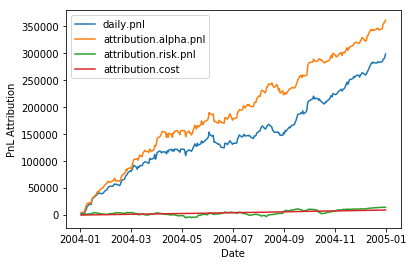

In [44]:
attr = build_pnl_attribution()

for column in attr.columns:
        plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

## Build portfolio characteristics (TODO)
Calculate the sum of long positions, short positions, net positions, gross market value, and amount of dollars traded.

In the code below, in the function `build_portfolio_characteristics` calculate the sum of long positions, short positions, net positions, gross market value, and amount of dollars traded.  

In [45]:
def build_portfolio_characteristics(): 
    df = pd.DataFrame(index = my_dates)
    
    for dt in my_dates:
        date = dt.strftime('%Y%m%d')
  
        p = port[date]
        tradelist = trades[date]
        h = p['opt.portfolio']['h.opt']
        
        # TODO: Implement
        
        ht = tradelist['h.opt']
        ht0 = tradelist['h.opt.previous']
        
        df.at[dt,"long"] = np.sum(h[h >= 0])
        df.at[dt,"short"] = np.sum(h[h < 0]) 
        df.at[dt,"net"] = np.sum(h)
        df.at[dt,"gmv"] = np.sum(abs(h))
        df.at[dt,"traded"] = np.sum(abs(ht-ht0))
        
    return df

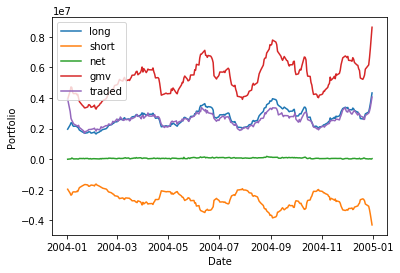

In [46]:
pchar = build_portfolio_characteristics()

for column in pchar.columns:
        plt.plot(pchar[column], label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Portfolio')
plt.show()

#### Optional
Choose additional metrics to evaluate your portfolio.

In [47]:
# Optional


## Submission
Now that you're done with the project, it's time to submit it. Click the submit button in the bottom right. One of our reviewers will give you feedback on your project with a pass or not passed grade.